In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
matplotlib.rcParams.update({'font.size': 20})
import seaborn as sns


## Load Data

In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'

In [3]:
#load threshold, SNR data

d_rename = {'Her2':'HER2','LaminAC':'LamAC','pH3':'pHH3'}
df_t = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/SNR_jenny_replicates.csv',index_col=0)
df_t.marker = df_t.marker.replace(to_replace=d_rename)
df_t['scene'] = [item.split('Scene-0')[1] for item in df_t.scene]
#load metadata from feature extraction
df_m = pd.read_csv(f'{codedir}/Metadata/BM-Her2N75/metadata_JennyReps.csv',index_col=0)

# import mean int

In [6]:
#import dataframes with mean intensity
df_mi =pd.DataFrame()
     
ls_sample =  ['BM-Her2N75-15','BM-Her2N75-17','BM-Her2N75-18']

for s_sample in ls_sample:
    df_tt = pd.read_csv(f'{codedir}/Data/features_{s_sample}-3S_MeanIntensity.csv',index_col=0)
    df_mi = df_mi.append(df_tt)
#add the slide/scene information 

df_mi['slide'] = [item.split('_')[0] for item in df_mi.index]

# Percent Positive

Thresholds were set on the images, using the pattern of staining to set an intensity value above which pixels were considered positive for a stain.

Here, the same theresholds are applied to the single cell mean intensity values. If a cell has a mean intensity above the pixel threshold, it is considered positive. Percent of positive cells over all segmented cells is calculated for each marker.

In [7]:
#calculate positive cells based on thresholding the mean intensity dataframe

#empty dataframe
df_pos = pd.DataFrame()
df_pos_cell = pd.DataFrame(index=df_mi.index)
#for each sample
for s_index in df_t.index:
    s_tissue = df_t.loc[s_index,'slide']
    s_marker = df_t.loc[s_index,'marker']
    s_scene = df_t.loc[s_index,'scene']
    df_m_slide = df_m[(df_m.slide==s_tissue) & (df_m.marker == s_marker)]
    if len(df_m_slide) !=1:
        print(df_m_slide)
    #when the features were extracted we had some exposure normalization ... need to undo
    i_thresh = df_t.loc[s_index,'threshold']/(df_m_slide.loc[:,'refexp']/df_m_slide.loc[:,'exposure'])
    s_marker_loc = df_mi.columns[pd.Series([item.split('_')[0]==s_marker for item in df_mi.columns])][0]
    df_slide = df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')]
    df_pos.loc[s_marker,f'{s_tissue}_s{s_scene}'] = ((df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')].loc[:,s_marker_loc] > i_thresh[0]).sum())/len(df_mi[(df_mi.slide==s_tissue)& (df_mi.scene==f'scene0{s_scene}')])
    df_pos_cell.loc[df_slide.index,s_marker_loc] = (df_slide.loc[:,s_marker_loc] > i_thresh[0])

In [8]:
#generate plotting dataframe
#percent pos
df_percent = pd.DataFrame()
df_15 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-15')]]
df_15.columns = [item.split('_s')[1] for item in df_15.columns]
df_17 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-17')]]
df_17.columns = [item.split('_s')[1] for item in df_17.columns]
df_18 = df_pos.loc[:,df_pos.columns[df_pos.columns.str.contains('N75-18')]]
df_18.columns = [item.split('_s')[1] for item in df_18.columns]

df1 = df_15/df_17
df2 = df_17/df_18
df3 = df_18/df_15

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    se_app = df_long.T.unstack()[s_marker]
    se_app.name = 'value'
    df_app = pd.DataFrame(se_app)
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.103292888133031
0.3897180653362968


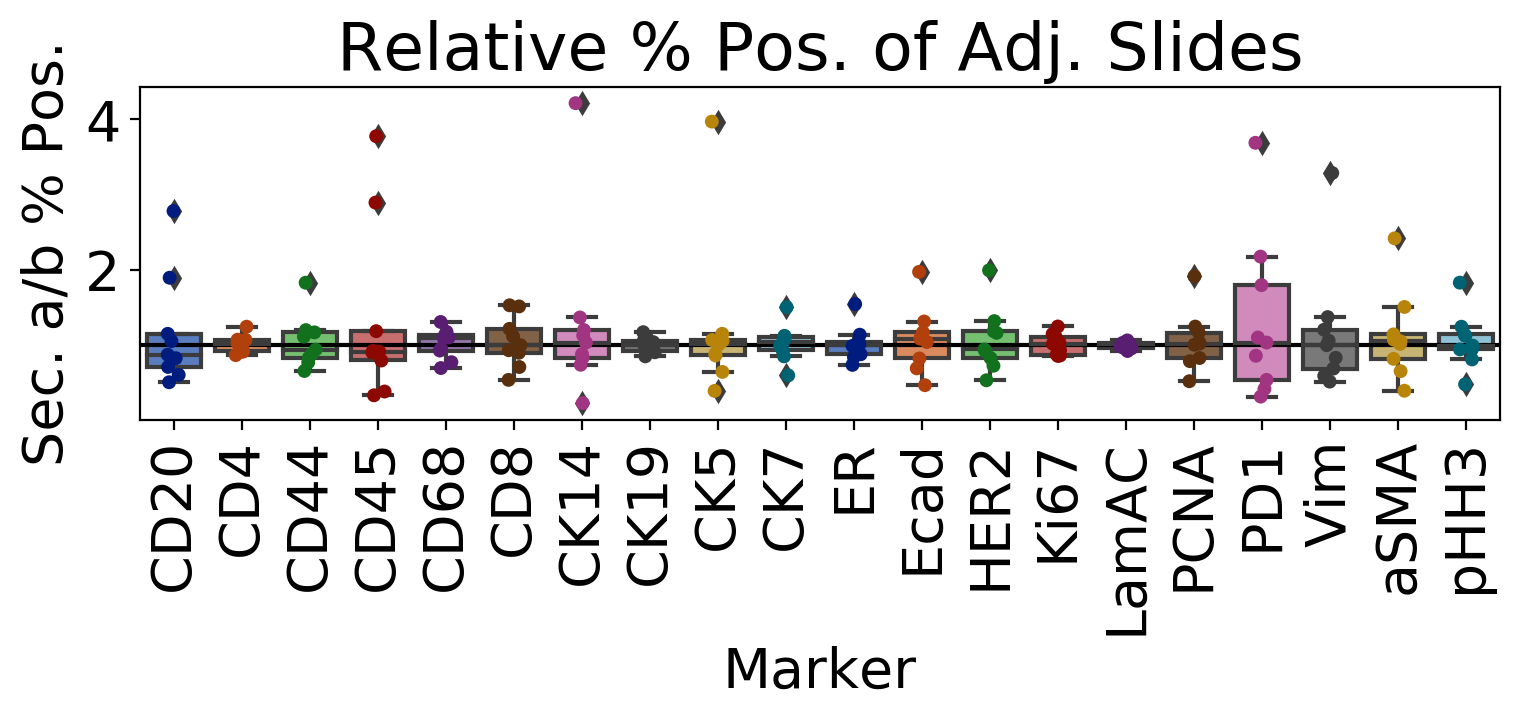

In [11]:
#boxplot
s_title = "Relative % Pos. of Adj. Slides"
s_ylabel = "Sec. a/b % Pos."
s_figname =f'{codedir}/Figures/BM-Her2N75/Percent_Positive_JennyReps_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,4.1)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)

# mean intensity 

The mean intensity of pixels above the threshold

In [12]:
#mean intensity
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).meanpos.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).meanpos.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).meanpos.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.1000486502357145
0.558508133715111


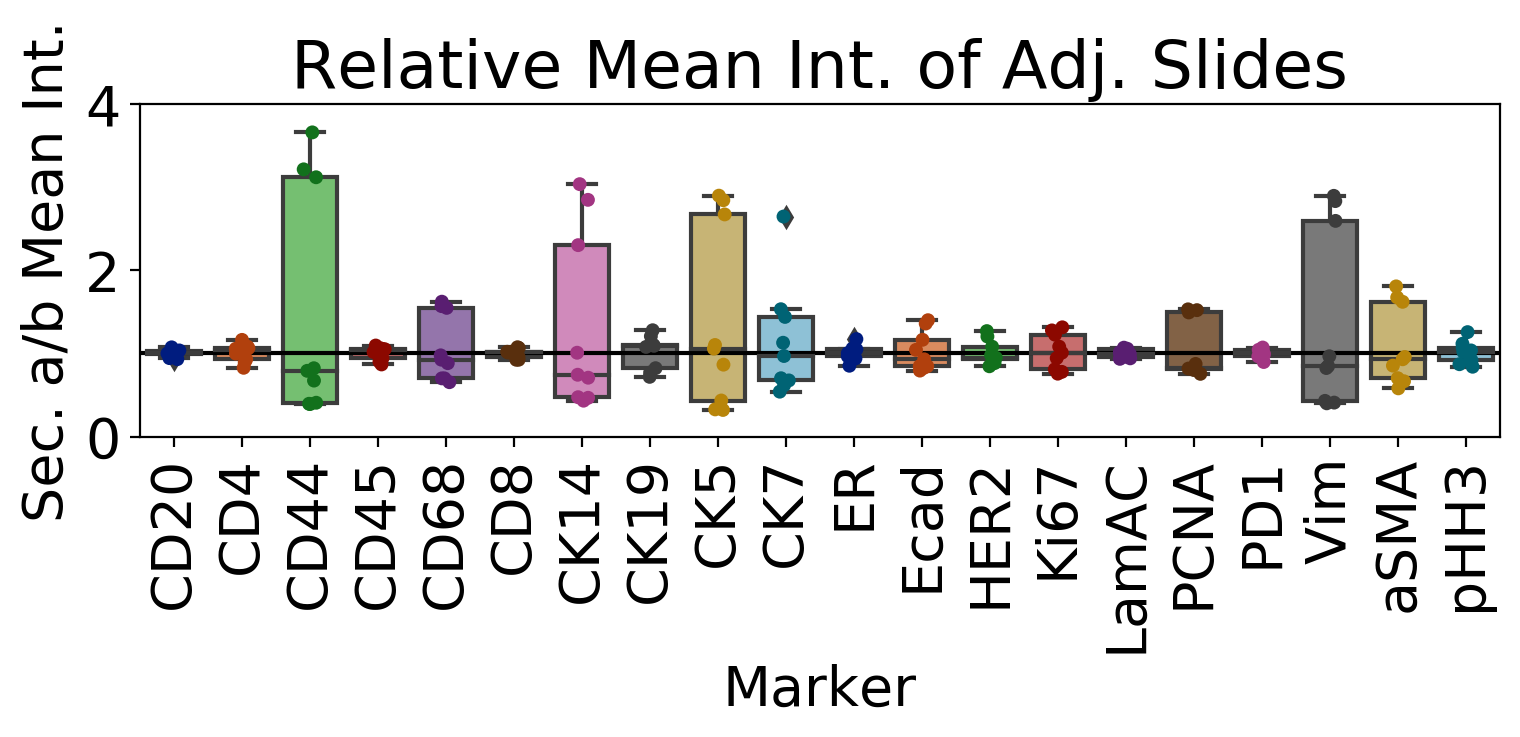

In [13]:
#boxplot

s_title = "Relative Mean Int. of Adj. Slides"
s_ylabel = "Sec. a/b Mean Int."

s_figname = f'{codedir}/Figures/BM-Her2N75/Mean_Intensity_Ratio_JennyReps_boxplot.png'

fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# background

The mean intensity of pixels below the threshold

In [14]:
#background

#mean intensity
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).meanneg.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).meanneg.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).meanneg.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.0542918048348704
0.3714688657979955


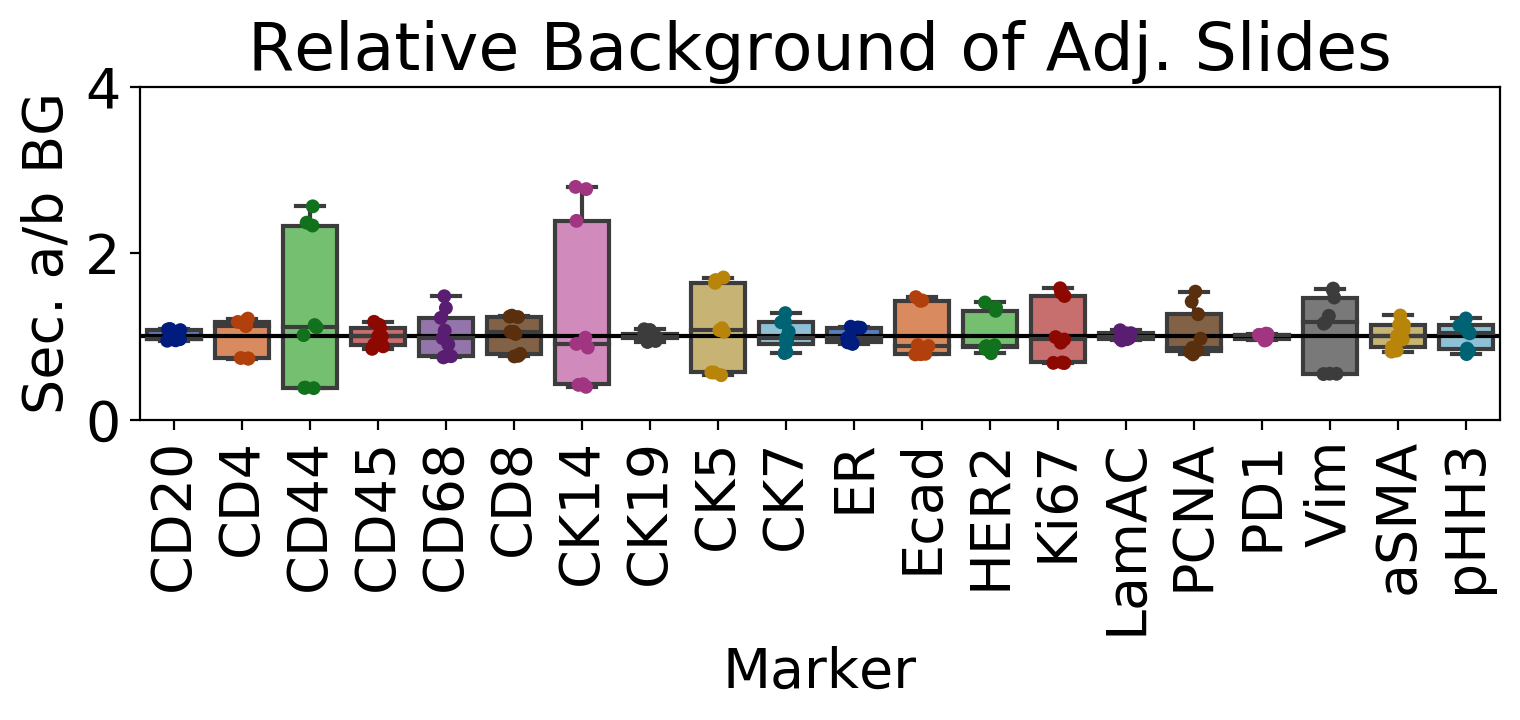

In [15]:
#yay
s_title = "Relative Background of Adj. Slides"
s_ylabel = "Sec. a/b BG"

s_figname =f'{codedir}/Figures/BM-Her2N75/Background_Noise_Ratio_JennyReps_boxplot.png'

fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# Signal to Background Ratio

SBR = mean intensity above threshold/mean intensity below threshold

compare SBR of rep1 relative to 2, rep2 to 3 and rep3 to 1

three tissues analyzed per TMA (so total n=9)

In [16]:
df_t['SNR'] = df_t.meanpos/df_t.meanneg

In [17]:
#generate plotting dataframe
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.slide=='BM-Her2N75-15']).groupby(['marker','scene']).SNR.mean())
df_17 = ((df_t[df_t.slide=='BM-Her2N75-17']).groupby(['marker','scene']).SNR.mean())
df_18 = ((df_t[df_t.slide=='BM-Her2N75-18']).groupby(['marker','scene']).SNR.mean())

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.0275335083065957
0.2369687564392439


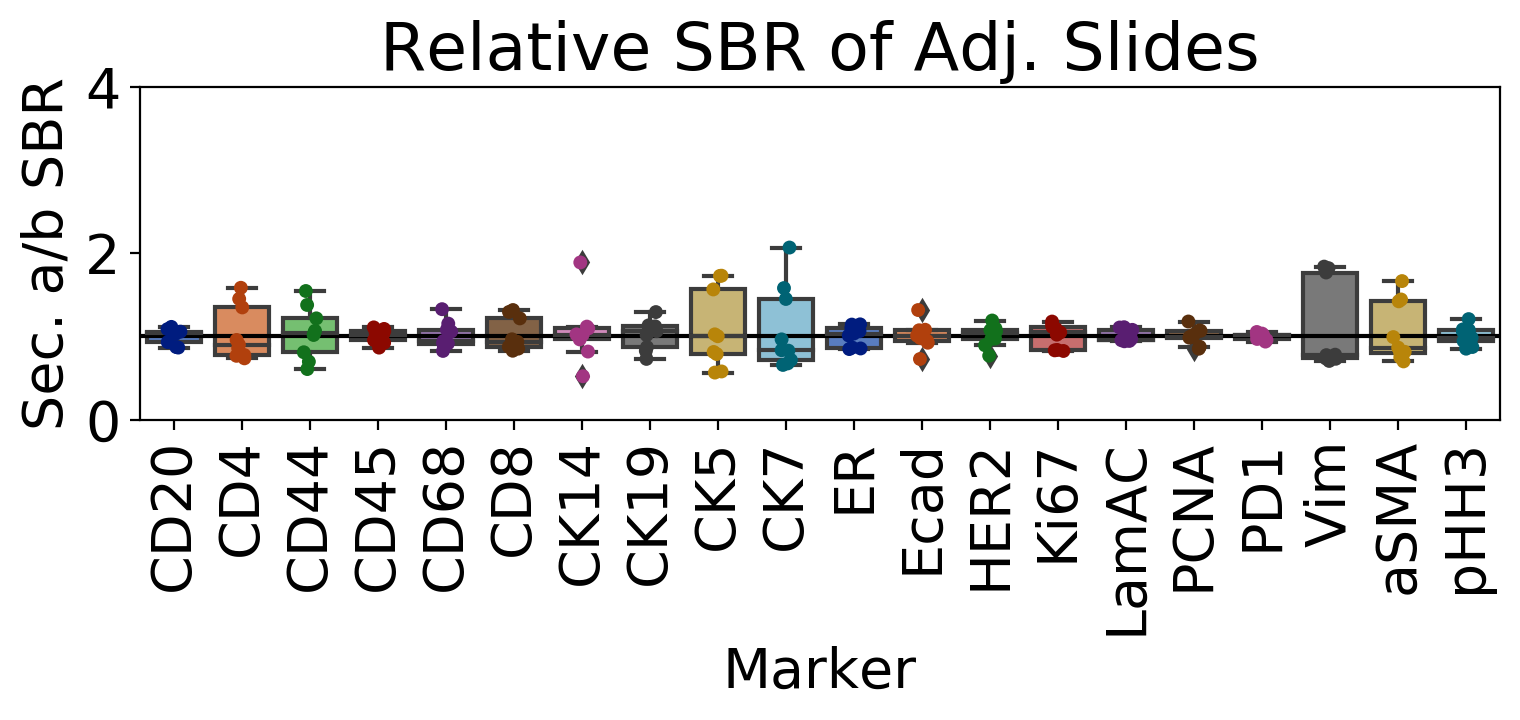

In [18]:

s_title = "Relative SBR of Adj. Slides"
s_ylabel = "Sec. a/b SBR"

s_figname =f'{codedir}/Figures/BM-Her2N75/SNR_Ratio_JennyReps__boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

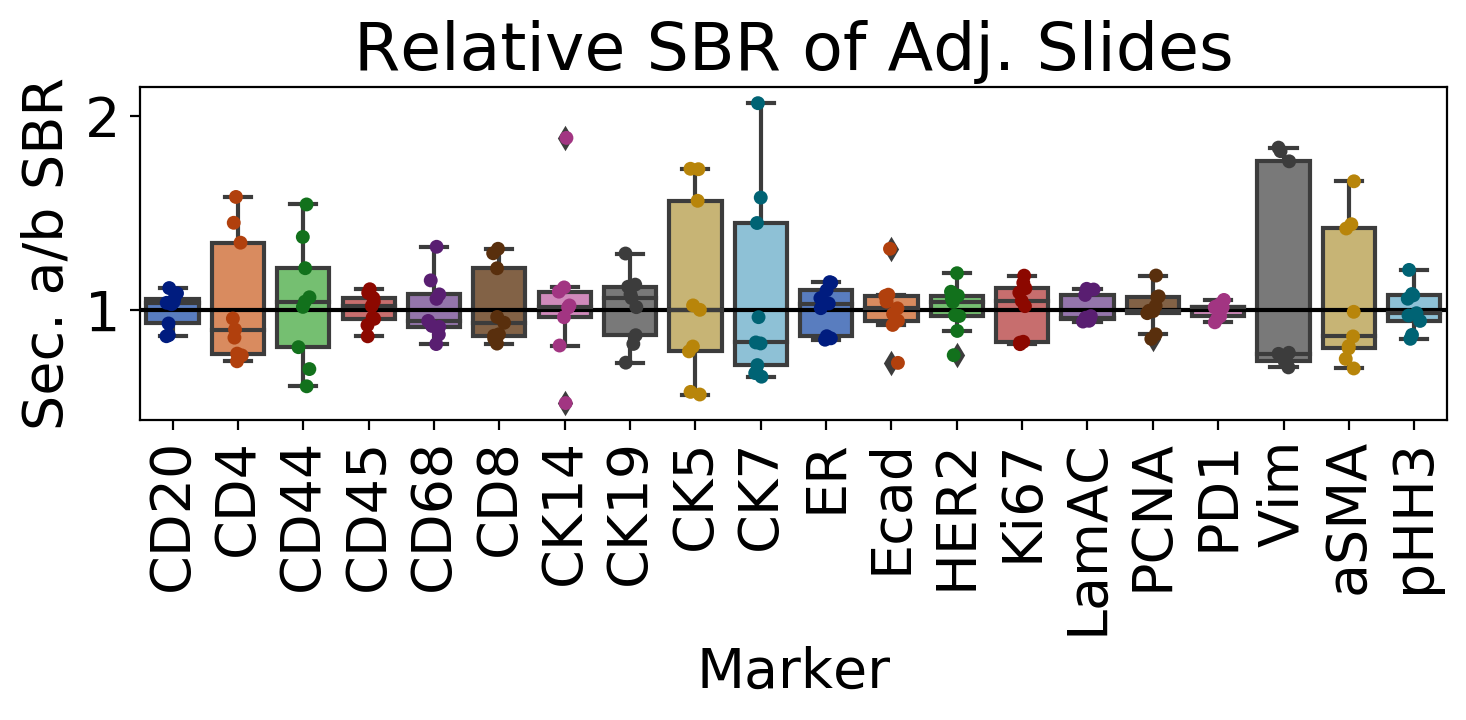

In [19]:
#zoomed in plot
s_title = "Relative SBR of Adj. Slides"
s_ylabel = "Sec. a/b SBR"

s_figname =f'{codedir}/Figures/BM-Her2N75/SNR_Ratio_JennyReps_zoomed_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
#df_plot = df_percent.sort_values('mean_ratio', ascending=False).loc[:,['mean_ratio','stand_dev']]
#df_plot.plot(kind='bar', yerr='stand_dev', ax=ax, title = s_title,legend=False)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)


plt.tight_layout()
fig.savefig(s_figname)

# Compare SBR btwn tissue

SBR = mean intensity above threshold/mean intensity below threshold

compare SBR of tissue 1 relative to 2, tissue2 to 3 and tissue3 to 1

(total n=9)

In [20]:
#gereate plotting dataframe
df_percent = pd.DataFrame()
df_15 = ((df_t[df_t.scene=='17']).groupby(['marker','slide']).SNR.mean()) #15 = 17
df_17 = ((df_t[df_t.scene=='49']).groupby(['marker','slide']).SNR.mean()) # 17 = 49
df_18 = ((df_t[df_t.scene=='59']).groupby(['marker','slide']).SNR.mean()) # 18 = 59

df1 = df_15.unstack()/df_17.unstack()
df2 = df_17.unstack()/df_18.unstack()
df3 = df_18.unstack()/df_15.unstack()

df_long = pd.DataFrame()
df_longer = pd.DataFrame()
df_long = df_long.append(df1)
df_long = df_long.append(df2)
df_long = df_long.append(df3)
for s_marker in df1.index:
    ls_app = df_long.loc[s_marker].unstack().values
    df_app = pd.DataFrame(ls_app,columns=['value'])
    df_app['marker'] = s_marker
    df_longer = df_longer.append(df_app)
#stats
print(df_long.mean(axis=1).mean())
print(df_long.mean(axis=1).std())

1.0832236111543325
0.5143293020262243


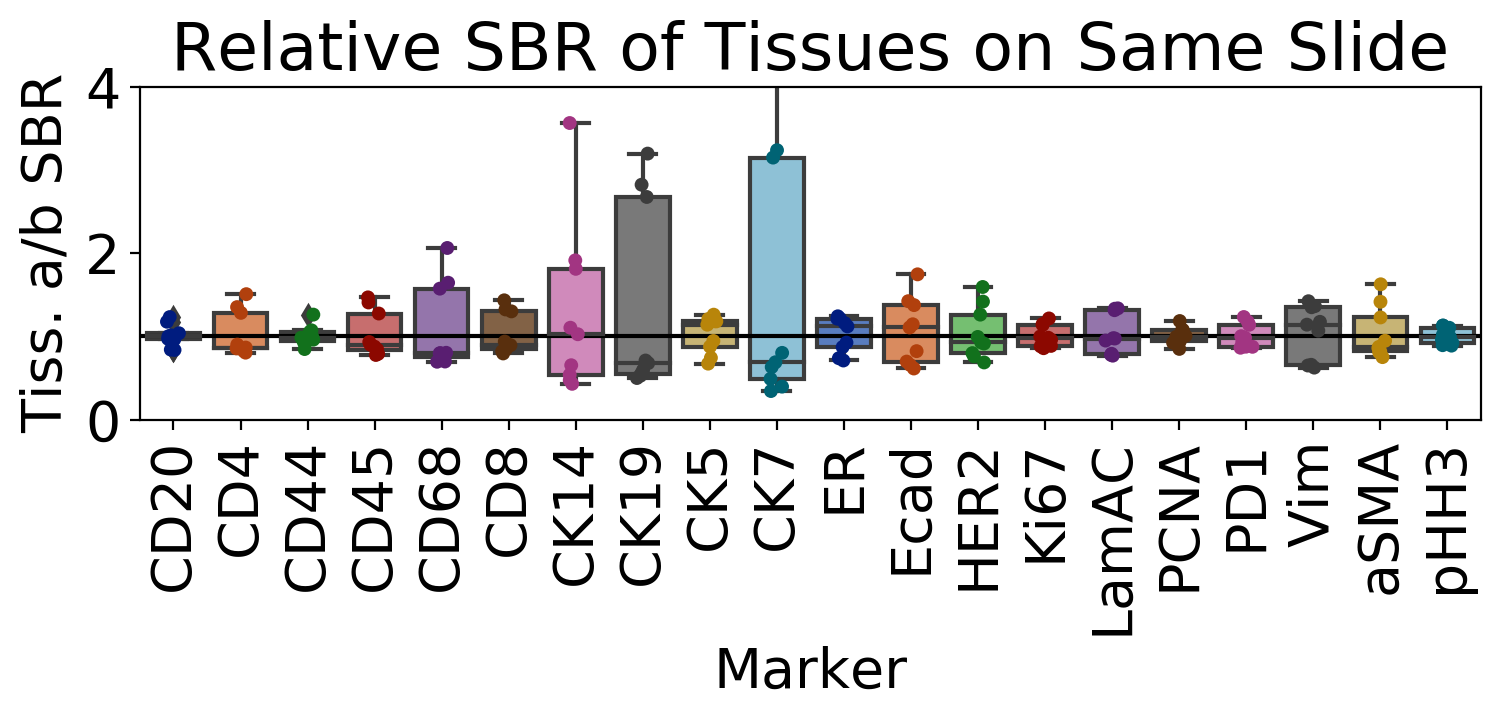

In [21]:
s_title = "Relative SBR of Tissues on Same Slide"
s_ylabel = "Tiss. a/b SBR"
s_figname =f'{codedir}/Figures/BM-Her2N75/Tissue_SNR_Ratio_JennyReps_boxplot.png'
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
sns.boxplot(data=df_longer, x='marker', y='value', palette = 'muted')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,4)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)
plt.tight_layout()
fig.savefig(s_figname)
